Detect cloud bands between on 23 and 30 Nov 2007 using ERA5 3 hourly olr data, and create maps showing the evolution of the cloud bands.

In [1]:
import cartopy.crs as ccrs

from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import os
import warnings

warnings.filterwarnings("ignore")

from cloudbandpy.load_driver import run_load_data
from cloudbandpy.cb_detection import detection_workflow
from cloudbandpy.misc import wrapTo180
from cloudbandpy.io_utilities import load_ymlfile, add_startend_datetime2config, get_variable_lonlat_from_domain


Load configuration file and make adjustements for this test case

In [2]:
config_file = "../config/config_cbworkflow_northPacific.yml"
config = load_ymlfile(config_file, isconfigfile=True)
config_event = config.copy()
# Changing configs to adapt to this particular example
config_event["startdate"] = "20071123.00"
config_event["enddate"] = "20071130.00"
# update datetime dates from config file
add_startend_datetime2config(config_event)
dirdata= "../data/"
config_event["clouddata_path"] = os.path.join("../data")
config_event["parameters_file"] = os.path.join("../parameters/parameters_northhemisphere.yml")
# No need to save any files
config_event["saved_dirpath"] = ""
config_event["save_dailyvar"] = False
config_event["save_listcloudbands"] = False

2023-11-23 17:18:41,986 - io_utilities.load_ymlfile - INFO: Configuration file loaded


Load ERA5 data and get its resolution, and load parameters file. The ERA5 file contains OLR data from 01.01.2016 to 30.05.2016.

In [3]:
olr2process, parameters, listofdates, lats_in, lons_in, resolution = run_load_data(config_event)

2023-11-23 17:18:41,992 - load_driver.run_load_data - INFO: Loading data and parameters 
2023-11-23 17:18:41,995 - io_utilities.load_ymlfile - INFO: Parameters file loaded
2023-11-23 17:18:41,996 - io_utilities.load_dataset - INFO: Loading dataset from ../data
2023-11-23 17:18:41,997 - io_utilities.load_dataset - INFO: Loading 2007 --> 2007
2023-11-23 17:18:55,855 - io_utilities.get_variable_lonlat_from_domain - INFO: Subsetting dataset on domain done
2023-11-23 17:18:55,858 - io_utilities.make_daily_average - INFO: Computation of daily average
2023-11-23 17:18:55,981 - io_utilities.make_daily_average - INFO: Computation of daily average done
2023-11-23 17:18:55,982 - io_utilities.load_dataset - INFO: Dataset loaded


Crop variable to domain of detection

In [4]:
lat_north = config_event["lat_north"]
lat_south = config_event["lat_south"]
lon_west = config_event["lon_west"]
lon_east = config_event["lon_east"]
olr, lons, lats = get_variable_lonlat_from_domain(olr2process, lons_in, lats_in, lon_west, lon_east, lat_north, lat_south)

2023-11-23 17:18:56,033 - io_utilities.get_variable_lonlat_from_domain - INFO: Subsetting dataset on domain done


Run cloud band detection

In [5]:
(
        _,
        _,
        labelled_blobs,
        labelled_candidates,
        cloud_bands_over_time,
        _,
        _,
    ) = detection_workflow(
        var2process=olr,
        parameters=parameters,
        latitudes=lats,
        longitudes=lons,
        resolution=resolution,
        listofdates=listofdates,
        config=config_event,
    )

2023-11-23 17:18:56,060 - cb_detection.detection_workflow - INFO: Cloud band detection in progress


2023-11-23 17:18:56,194 - cb_detection.detection_workflow - INFO: Cloud band detection done


Create the series of maps which show the evolution of cloud bands over time

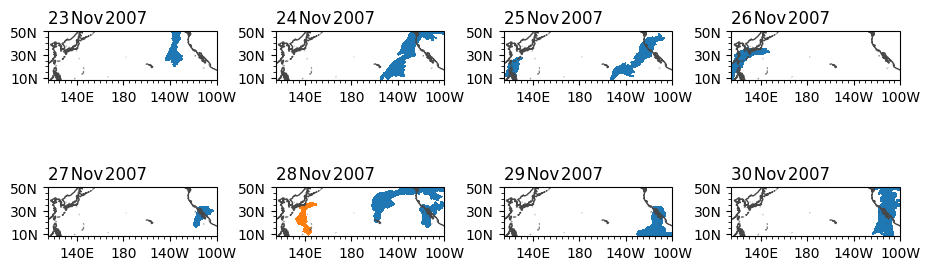

In [6]:
LON_FORMAT = LongitudeFormatter(zero_direction_label=True, degree_symbol="")
LAT_FORMAT = LatitudeFormatter(degree_symbol="")
lat_north, lat_south = round(lats[0]), round(lats[-1])
daystart = f"{listofdates[0].day}-{listofdates[0].strftime('%m')}-{listofdates[0].year}"
dayend = f"{listofdates[-1].day}-{listofdates[-1].strftime('%m')}-{listofdates[-1].year}"
#
from matplotlib.ticker import MultipleLocator

fig, axs = plt.subplots(
    nrows=2,
    ncols=4,
    subplot_kw={"projection": ccrs.PlateCarree(central_longitude=180)},
    figsize=(11, 4),
)
for inc, ax in enumerate(axs.ravel()):
    ax.contourf(
        lons, lats, np.ma.masked_where(cloud_bands_over_time[inc] == 0, cloud_bands_over_time[inc]),
        transform=ccrs.PlateCarree(), levels=range(20), cmap="tab10",
    )
    lonticks = np.concatenate((np.arange(20,180,40),np.arange(-200, 0, 40)))
    latticks = np.arange(-90, 110, 20)
    ax.set_xticks(lonticks, crs=ccrs.PlateCarree())
    ax.set_yticks(latticks, crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LON_FORMAT)
    ax.yaxis.set_major_formatter(LAT_FORMAT)
    ax.minorticks_on()
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.xaxis.set_major_locator(MultipleLocator(40))
    ax.set_extent([wrapTo180(lons)[-1], wrapTo180(lons)[0], lat_south, lat_north])
    ax.set_ylim([lat_south, lat_north])
    ax.coastlines(color="#474747")
    ax.set_title(
        f"{listofdates[inc].day}\u200A{listofdates[inc].strftime('%b')}\u200A{listofdates[inc].year}",
        loc="left",
    )
#
fig.subplots_adjust(wspace=0.35, hspace=0.025)